In [2]:
import numpy as np
import matplotlib.pyplot as plt

from landlab import RasterModelGrid
from landlab.plot import imshow_grid

The conservation of mass for an isothermal, shallow, non-sliding ice mass states:
$$
\frac{\partial H}{\partial t} = \dot{m} - \nabla\cdot\left[\Gamma H^{n + 2}|\nabla s|^{n - 1}\nabla s\right],
$$
where $H$ is the thickness of the ice mass, $\dot{m}$ is the specific mass balance, $n$ is Glen's flow law exponent, and $s$ is the ice surface slope, such that $H = s - b$ for some bed elevation $b$. The coefficient $\Gamma$ is given by:
$$
\Gamma = \frac{2A(\rho g)^n}{n + 2}. 
$$

In [4]:
class ShallowIce:
    sec_per_a = 3.14e7
    glens_n = 3
    glens_coeff = 1e-16 / sec_per_a
    ice_density = 917 # kg m^-3
    gravity = 9.81 # m s^-2
    
    def __init__(self, Nx, Ny, dx, dy):
        
        # Set up the grid
        self.grid = RasterModelGrid((Nx, Ny), (dx, dy))
        
        # Initialize empty fields
        self.grid.add_empty('ice_thickness', at = 'node')
        self.grid.add_empty('ice_surface', at = 'node')
        self.grid.add_empty('bed_elevation', at = 'node')
        self.grid.add_empty('mass_balance', at = 'node')
        self.grid.add_empty('diffusivity', at = 'node')        
        self.grid.add_empty('dH_dt', at = 'node')
        
        # Set initial conditons
        self.calc_fluidity()
        
    def calc_fluidity(self):
        self.fluidity = (2 * self.glens_coeff * (self.ice_density * self.gravity)**self.glens_n) / (self.glens_n + 2)
        
    def update_surface(self):
        self.grid.at_node['ice_thickness'][:] = np.where(self.grid.at_node['ice_thickness'][:] >= 0, self.grid.at_node['ice_thickness'][:], 0.0)
        self.grid.at_node['ice_surface'][:] = self.grid.at_node['ice_thickness'][:] - self.grid.at_node['bed_elevation'][:]
    
    def calc_diffusivity(self):
        surface_slope = self.grid.calc_slope_at_node('ice_surface')
        self.grid.at_node['diffusivity'][:] = self.fluidity * self.grid.at_node['ice_thickness'][:]**(self.glens_n + 2) * surface_slope**(self.glens_n - 1)
    
    def run_one_step(self):
        self.update_surface()
        self.calc_diffusivity()
        
    
    

In [5]:
def fracpower(q, p):
    return np.abs(q)**p * np.sign(q)

In [36]:
N = 1000
d = 100
sia = ShallowIce(N, N, d, d)
sia.grid.at_node['bed_elevation'][:] = 0.0

origin = [N * d / 2, N * d / 2]
radius = np.sqrt((sia.grid.node_x - origin[0])**2 + (sia.grid.node_y - origin[1])**2)
M0 = 0.3
L = 40 * N
H = (4 * M0 / sia.fluidity)**(1/8) * fracpower(L**(4/3) - radius**(4/3), 3/8)
H = np.where(H < 0, 0.0, H)
sia.grid.at_node['ice_thickness'][:] = H

sia.update_surface()

sia.grid.at_node['mass_balance'][:] = 0.0

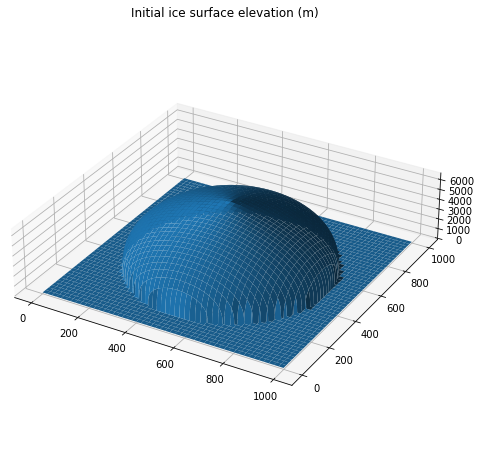

In [43]:
fig, ax = plt.subplots(figsize = (8, 8), subplot_kw = {"projection": "3d"})

nx = N
ny = N
x, y = np.meshgrid(range(nx), range(ny))
z = sia.grid.at_node['ice_thickness'].reshape((nx, ny))

ax.plot_surface(x, y, z)
ax.set_box_aspect([1, 1, 0.25])

plt.title('Initial ice surface elevation (m)')
plt.show()

In [69]:
sia.calc_diffusivity()
slope_gradient_links = sia.grid.calc_grad_at_link('ice_surface')
slope_gradient = sia.grid.map_upwind_node_link_mean_to_node(slope_gradient_links)
flux = sia.grid.at_node['diffusivity'][:] * slope_gradient
flux_dx = sia.grid.map_mean_of_horizontal_links_to_node(sia.grid.calc_diff_at_link(flux))
flux_dy = sia.grid.map_mean_of_vertical_links_to_node(sia.grid.calc_diff_at_link(flux))
div_flux = flux_dx + flux_dy

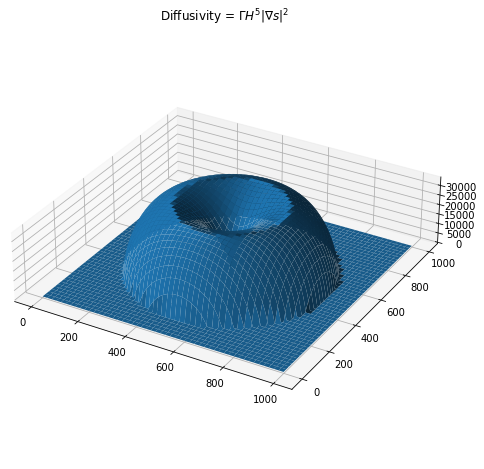

In [58]:
fig, ax = plt.subplots(figsize = (8, 8), subplot_kw = {"projection": "3d"})

nx = N
ny = N
x, y = np.meshgrid(range(nx), range(ny))
z = sia.grid.at_node['diffusivity'].reshape((nx, ny))

ax.plot_surface(x, y, z)
ax.set_box_aspect([1, 1, 0.25])

plt.title('Diffusivity = $\Gamma H^5 |\\nabla s|^2$')
plt.show()

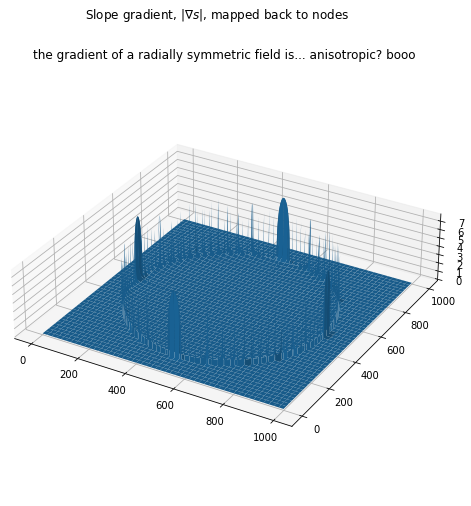

In [99]:
fig, ax = plt.subplots(figsize = (8, 8), subplot_kw = {"projection": "3d"})

nx = N
ny = N
x, y = np.meshgrid(range(nx), range(ny))
z = slope_gradient.reshape((nx, ny))

ax.plot_surface(x, y, z)
ax.set_box_aspect([1, 1, 0.25])

plt.suptitle('Slope gradient, |$\\nabla s$|, mapped back to nodes')
plt.title('the gradient of a radially symmetric field is... anisotropic? booo')
plt.show()

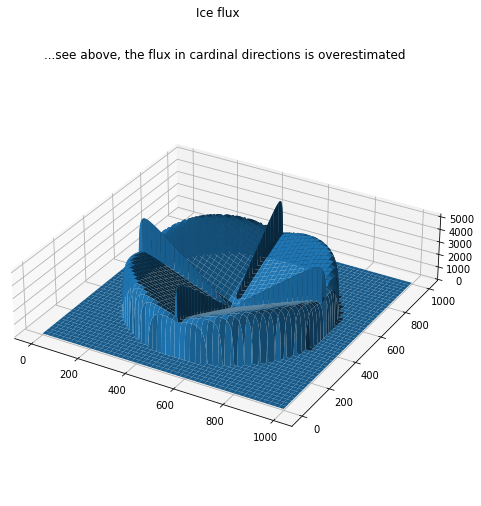

In [92]:
fig, ax = plt.subplots(figsize = (8, 8), subplot_kw = {"projection": "3d"})

nx = N
ny = N
x, y = np.meshgrid(range(nx), range(ny))
z = flux.reshape((nx, ny))

ax.plot_surface(x, y, z)
ax.set_box_aspect([1, 1, 0.25])

plt.suptitle('Ice flux')
plt.title('...see above, the flux in cardinal directions is overestimated')
plt.show()

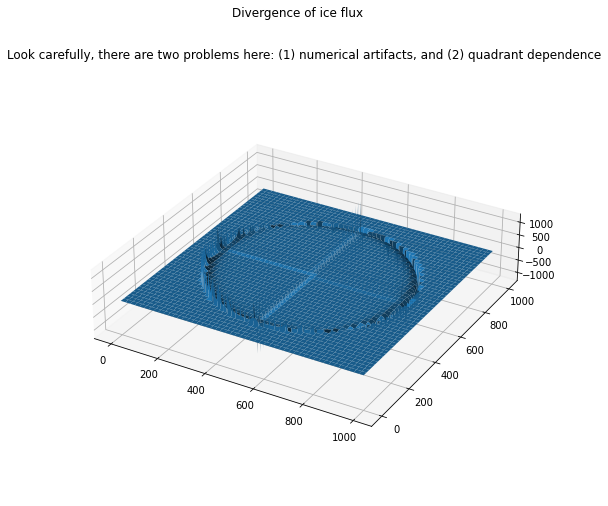

In [91]:
fig, ax = plt.subplots(figsize = (8, 8), subplot_kw = {"projection": "3d"})

nx = N
ny = N
x, y = np.meshgrid(range(nx), range(ny))
z = div_flux.reshape((nx, ny))

ax.plot_surface(x, y, z)
ax.set_box_aspect([1, 1, 0.25])

plt.suptitle('Divergence of ice flux')
plt.title('Look carefully, there are two problems here: (1) numerical artifacts, and (2) quadrant dependence')
plt.show()